In [47]:
import polars as pl
import os
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import seaborn as sns

load_dotenv()

True

In [48]:
cfg = pl.Config()
cfg.set_tbl_rows(100)
cfg.set_fmt_str_lengths(200)

polars.config.Config

In [49]:
uri = os.environ.get("DB_URI")

In [50]:
# if false, will read existing parquet files
READ_DB = False

In [ ]:
if READ_DB:
    local_query = """
  -- Find trip_ids that stopped at BOTH Nostrand (248) AND Kingston (249)
  WITH local_trips AS (
      SELECT trip_id
      FROM stop_time
      WHERE stop_id IN (248, 249) -- Stopped at Nostrand or Kingston
      GROUP BY trip_id
      HAVING COUNT(DISTINCT stop_id) = 2 -- Ensure the trip stopped at *both*
  )
  -- Select the Franklin (239) and Utica (250) stops ONLY for those local trips
  SELECT st.trip_id,
      st.stop_id,
      st.arrival,
      st.departure,
      st.scheduled_track,
      st.actual_track,
      t.mta_id,
      t.created_at,
      t.updated_at,
      t.route_id
  FROM stop_time st
  JOIN trip t ON st.trip_id = t.id
  WHERE st.stop_id IN (239, 250) -- Select Franklin or Utica stops
    AND t.direction = 0
    AND t.assigned = True
    AND st.trip_id IN (SELECT trip_id FROM local_trips) -- Only include trips identified in the CTE
  """
    df_lcl = pl.read_database_uri(query=local_query, uri=uri)
    df_lcl.write_parquet(r"data/local_trips.parquet")
else:
    df_lcl = pl.read_parquet(r"data/local_trips.parquet")

In [ ]:
if READ_DB:
    express_query = """
  WITH
    -- Trips that stopped at BOTH Franklin (239) AND Utica (250)
    trips_at_239_250 AS (
      SELECT trip_id
      FROM stop_time
      WHERE stop_id IN (239, 250)
      GROUP BY trip_id
      HAVING COUNT(DISTINCT stop_id) = 2
    ),
    -- Trips that stopped at EITHER Nostrand (248) OR Kingston (249)
    trips_at_248_or_249 AS (
      SELECT DISTINCT trip_id
      FROM stop_time
      WHERE stop_id IN (248, 249)
    )
  -- Select Franklin (239) and Utica (250) stops for trips that
  -- stopped at 239 AND 250, but NOT at 248 OR 249.
  SELECT
    st.trip_id,
    st.stop_id,
    st.arrival,
    st.departure,
    st.scheduled_track,
    st.actual_track,
    t.mta_id,
    t.created_at,
    t.updated_at,
    t.route_id
  FROM stop_time st
  JOIN trip t ON st.trip_id = t.id
  WHERE
    st.stop_id IN (239, 250)       -- Only get the rows for these stops
    AND t.direction = 0
    AND t.assigned = True
    AND st.trip_id IN (SELECT trip_id FROM trips_at_239_250) -- Must have stopped at both 239 & 250
    AND st.trip_id NOT IN (SELECT trip_id FROM trips_at_248_or_249) -- Must NOT have stopped at 248 or 249
  """
    df_exp = pl.read_database_uri(query=express_query, uri=uri)
    df_exp.write_parquet(r"data/express_trips.parquet")
else:
    df_exp = pl.read_parquet(r"data/express_trips.parquet")

In [54]:
df_exp = df_exp.sort(by=["trip_id", "stop_id"])
df_lcl = df_lcl.sort(by=["trip_id", "stop_id"])

In [55]:
# convert from UTC to EST
df_exp = df_exp.with_columns(
    arrival=pl.col("arrival").dt.convert_time_zone("America/New_York"),
    departure=pl.col("departure").dt.convert_time_zone("America/New_York"),
)
df_lcl = df_lcl.with_columns(
    arrival=pl.col("arrival").dt.convert_time_zone("America/New_York"),
    departure=pl.col("departure").dt.convert_time_zone("America/New_York"),
)

In [ ]:
# These trips stopped at 239, 250, 248, AND 249 based on the SQL query
local_stops = df_lcl.select(["trip_id", "stop_id", "arrival"]).pivot(
    index="trip_id", on="stop_id", values="arrival"
)
# Rename columns for clarity
local_stops = local_stops.rename({"239": "arrival_239", "250": "arrival_250"})
# Filter trips that stop at both stations (should be guaranteed by query, but good practice)
local_stops = local_stops.filter(
    pl.col("arrival_239").is_not_null() & pl.col("arrival_250").is_not_null()
)
# Rename columns for join and sort by arrival at Franklin
local_trips_pivoted = local_stops.rename(
    {
        "trip_id": "trip_id_local",  # Renamed to avoid confusion if route_id isn't 3
        "arrival_239": "arrival_local_239",
        "arrival_250": "arrival_local_250",
    }
).sort("arrival_local_239")


# --- Pivot Express Trips (df_exp) ---
# These trips stopped at 239, 250 but NOT 248 or 249 based on the SQL query
express_stops = df_exp.select(["trip_id", "stop_id", "arrival"]).pivot(
    index="trip_id", on="stop_id", values="arrival"
)
# Rename columns for clarity
express_stops = express_stops.rename({"239": "arrival_239", "250": "arrival_250"})
# Filter trips that stop at both stations (should be guaranteed by query)
express_stops = express_stops.filter(
    pl.col("arrival_239").is_not_null() & pl.col("arrival_250").is_not_null()
)
# Rename columns for join and sort by arrival at Franklin
express_trips_pivoted = express_stops.rename(
    {
        "trip_id": "trip_id_express",  # Renamed to avoid confusion if route_id isn't 4
        "arrival_239": "arrival_express_239",
        "arrival_250": "arrival_express_250",
    }
).sort("arrival_express_239")


# --- Use join_asof ---
# For each express-pattern trip, find the *next* local-pattern trip
# that arrives at Franklin (239) strictly *after* the express trip but within 15 minutes.
paired_trips = express_trips_pivoted.join_asof(
    local_trips_pivoted,
    left_on="arrival_express_239",  # Time on the left DF (express pattern trip)
    right_on="arrival_local_239",  # Time on the right DF (local pattern trip)
    strategy="forward",  # Find the first local train *after* or at the express train time
    tolerance="15m",  # Match if arrival_local_239 is within 15 mins *after* arrival_express_239
)

## Event Space

- All southbound 3 and 4 trains

## Events we are looking for:

- 3 train arriving after the 4 train at Franklin (stop ID 239) but before that 4 train at Utica Ave (stop ID 250)

## Process

1. For each 4 trip, find a 3 trip that arrives < 5 minutes after 4 to Franklin
2. Check if 3 trip arrived before the 4 trip to Utica ave


In [ ]:
# Create a pivot table to get arrival times for each trip at each stop
trip_stops = df.select(["trip_id", "route_id", "stop_id", "arrival"]).pivot(
    index=["trip_id", "route_id"], on="stop_id", values="arrival"
)
# Rename columns for clarity
trip_stops = trip_stops.rename({"239": "arrival_239", "250": "arrival_250"})

# Filter trips that stop at both stations
trip_stops = trip_stops.filter(
    pl.col("arrival_239").is_not_null() & pl.col("arrival_250").is_not_null()
)

# Separate route 3 and route 4 trips
local_trips = trip_stops.filter(pl.col("route_id").str.contains("2|3")).drop("route_id")
express_trips = trip_stops.filter(pl.col("route_id").str.contains("4|5")).drop(
    "route_id"
)

# Rename columns *before* the join and sort by the join key (arrival at Franklin)
local_trips = local_trips.rename(
    {
        "trip_id": "trip_id_3",
        "arrival_239": "arrival_3_239",
        "arrival_250": "arrival_3_250",
    }
).sort("arrival_3_239")

express_trips = express_trips.rename(
    {
        "trip_id": "trip_id_4",
        "arrival_239": "arrival_4_239",
        "arrival_250": "arrival_4_250",
    }
).sort("arrival_4_239")


# --- Use join_asof ---
# For each 4 train trip, find the *next* 3 train trip that arrives at Franklin (239)
# strictly *after* the 4 train but within 5 minutes.
paired_trips = express_trips.join_asof(
    local_trips,
    left_on="arrival_4_239",  # Time on the left DF (4 train)
    right_on="arrival_3_239",  # Time on the right DF (3 train)
    strategy="forward",  # Find the first 3 train *after* or at the 4 train time
    tolerance="15m",  # Match if arrival_3_239 is within 5 mins *after* arrival_4_239
)

In [ ]:
result = (
    paired_trips.filter(
        pl.col("trip_id_3").is_not_null()  # A match was found within tolerance
        & (
            pl.col("arrival_3_239") > pl.col("arrival_4_239")
        )  # Strictly after at Franklin
        & (
            pl.col("arrival_3_250") < pl.col("arrival_4_250")
        )  # 3 train arrives earlier at Utica
    )
    .with_columns(
        [
            # Time difference at Franklin (3 arrival - 4 arrival) -> should be 0 < diff <= 5 mins
            (
                (pl.col("arrival_3_239") - pl.col("arrival_4_239")).dt.total_seconds()
                / 60
            ).alias("time_diff_239_min"),
            # Time difference at Utica (4 arrival - 3 arrival) -> positive means 3 won
            (
                (pl.col("arrival_4_250") - pl.col("arrival_3_250")).dt.total_seconds()
                / 60
            ).alias("time_diff_250_min"),
        ]
    )
    .sort("arrival_4_239")  # Sort chronologically by the 4 train's arrival
)


In [28]:
# result.sort("time_diff_250_min", descending=True)
# result.filter(pl.col())
result

trip_id_4,arrival_4_250,arrival_4_239,trip_id_3,arrival_3_250,arrival_3_239,time_diff_239_min,time_diff_250_min
str,"datetime[μs, America/New_York]","datetime[μs, America/New_York]",str,"datetime[μs, America/New_York]","datetime[μs, America/New_York]",f64,f64
"""0195a4d6-d70f-79b1-9105-e0b8c6343aa4""",2025-03-17 13:51:02 EDT,2025-03-17 13:45:07 EDT,"""0195a4ed-9c04-7f70-9ce2-b185c2a330f4""",2025-03-17 13:50:45 EDT,2025-03-17 13:45:26 EDT,0.316667,0.283333
"""0195a529-3fcc-70f0-93b9-f25eadcf998d""",2025-03-17 15:12:30 EDT,2025-03-17 15:05:36 EDT,"""0195a536-d4a1-7a91-92c1-df9fef2986cf""",2025-03-17 15:12:09 EDT,2025-03-17 15:06:43 EDT,1.116667,0.35
"""0195a5bb-5c51-7630-8be7-da1040a26765""",2025-03-17 18:10:10 EDT,2025-03-17 18:03:42 EDT,"""0195a5d2-bb58-7931-87b8-6e310821da37""",2025-03-17 18:09:01 EDT,2025-03-17 18:03:46 EDT,0.066667,1.15
"""0195a6b6-d7ba-7360-b381-5b0e031e5855""",2025-03-17 21:39:30 EDT,2025-03-17 21:31:57 EDT,"""0195a692-974c-78b2-9dd5-050730b31b8b""",2025-03-17 21:37:30 EDT,2025-03-17 21:32:00 EDT,0.05,2.0
"""0195a6be-f506-7210-a27d-78668ede181b""",2025-03-17 21:49:32 EDT,2025-03-17 21:35:53 EDT,"""0195a6b1-6ee7-76b3-b7db-8a5061a31c2c""",2025-03-17 21:42:21 EDT,2025-03-17 21:36:39 EDT,0.766667,7.183333
"""0195a689-63aa-7ed0-9505-f55b6849651f""",2025-03-17 21:55:20 EDT,2025-03-17 21:40:02 EDT,"""0195a69b-c9be-7e81-aaf7-fd2c24b85259""",2025-03-17 21:47:30 EDT,2025-03-17 21:42:00 EDT,1.966667,7.833333
"""0195a692-9751-7202-8173-aa54800cf3ca""",2025-03-17 22:00:08 EDT,2025-03-17 21:44:35 EDT,"""0195a6a4-fe58-72d2-b4a9-c42bdee5b201""",2025-03-17 21:57:23 EDT,2025-03-17 21:52:12 EDT,7.616667,2.75
"""0195a8cf-78d2-7a70-8c7e-fea33e2ee023""",2025-03-18 08:22:33 EDT,2025-03-18 08:13:05 EDT,"""0195a8d8-b14c-7383-ba5a-28e70d60efb7""",2025-03-18 08:19:57 EDT,2025-03-18 08:14:09 EDT,1.066667,2.6
"""0195a8e6-430c-7770-af4f-23c75bc46181""",2025-03-18 08:44:07 EDT,2025-03-18 08:35:44 EDT,"""0195a8ef-7c25-7253-83a8-cc7a9d579f06""",2025-03-18 08:41:55 EDT,2025-03-18 08:36:16 EDT,0.533333,2.2


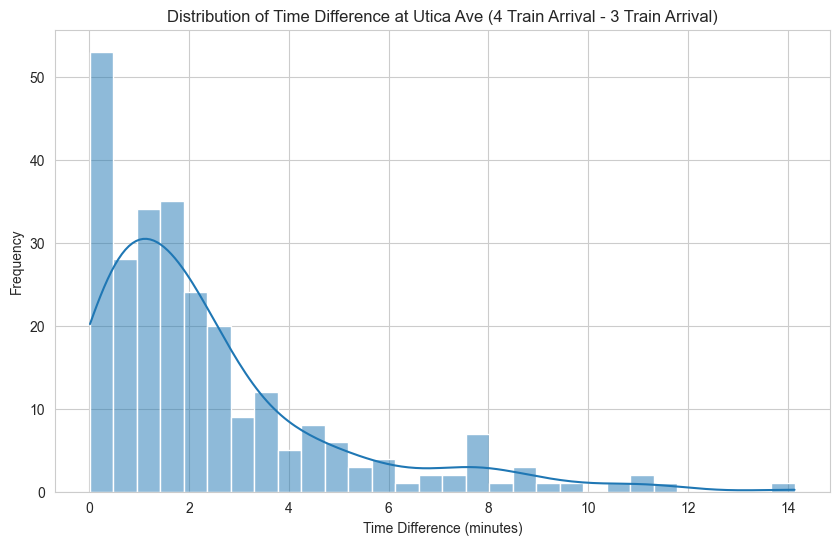

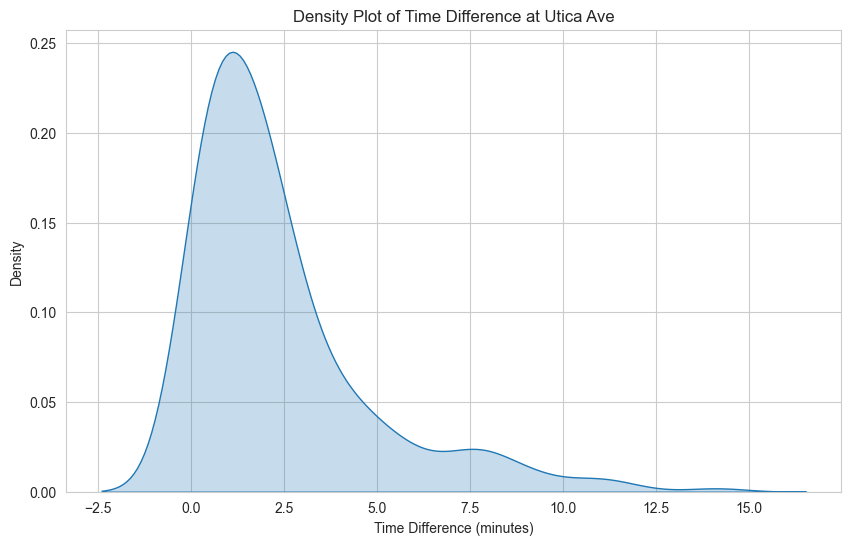

Descriptive Statistics for time_diff_250_min:
shape: (9, 2)
┌────────────┬───────────┐
│ statistic  ┆ value     │
│ ---        ┆ ---       │
│ str        ┆ f64       │
╞════════════╪═══════════╡
│ count      ┆ 264.0     │
│ null_count ┆ 0.0       │
│ mean       ┆ 2.392298  │
│ std        ┆ 2.45558   │
│ min        ┆ 0.016667  │
│ 25%        ┆ 0.683333  │
│ 50%        ┆ 1.7       │
│ 75%        ┆ 2.933333  │
│ max        ┆ 14.133333 │
└────────────┴───────────┘


In [29]:
sns.set_style("whitegrid")

# 1. Histogram
plt.figure(figsize=(10, 6))
sns.histplot(
    data=result, x="time_diff_250_min", bins=30, kde=True
)  # kde=True adds a density curve
plt.title(
    "Distribution of Time Difference at Utica Ave (4 Train Arrival - 3 Train Arrival)"
)
plt.xlabel("Time Difference (minutes)")
plt.ylabel("Frequency")
plt.show()

# 2. Box Plot (useful if you later group by time of day, etc.)
# plt.figure(figsize=(8, 4))
# sns.boxplot(data=result, x="time_diff_250_min")
# plt.title("Box Plot of Time Difference at Utica Ave")
# plt.xlabel("Time Difference (minutes)")
# plt.show()

# 3. Density Plot (Smoother version of histogram)
plt.figure(figsize=(10, 6))
sns.kdeplot(data=result, x="time_diff_250_min", fill=True)
plt.title("Density Plot of Time Difference at Utica Ave")
plt.xlabel("Time Difference (minutes)")
plt.ylabel("Density")
plt.show()

# --- Basic Statistics ---
print("Descriptive Statistics for time_diff_250_min:")
print(result["time_diff_250_min"].describe())

In [ ]:
# result.filter(pl.col("time_diff_250_min") < 10).unique(["trip_id_3", "trip_id_4"])
# result.sort("time_diff_250_min", descending=True).head(500).tail(5)


trip_id_3,arrival_3_250,arrival_3_239,trip_id_4,arrival_4_250,arrival_4_239,time_diff_239_min,time_diff_250_min
str,"datetime[μs, America/New_York]","datetime[μs, America/New_York]",str,"datetime[μs, America/New_York]","datetime[μs, America/New_York]",f64,f64
"""0195a47d-564e-7182-9c9a-368954d7b558""",2025-03-17 10:45:45 EDT,2025-03-17 10:37:51 EDT,"""01966981-c825-7120-ae48-c2f831fe2253""",2025-04-24 18:16:29 EDT,2025-04-24 18:09:30 EDT,55171.65,55170.733333
"""0195a47d-564a-7911-989d-72dc09acf747""",2025-03-17 11:10:42 EDT,2025-03-17 11:04:07 EDT,"""0196699e-9773-70c1-90a0-53ce1d64a843""",2025-04-24 18:41:26 EDT,2025-04-24 18:37:52 EDT,55173.75,55170.733333
"""0195a47d-564c-7552-9a31-7fe99b51f204""",2025-03-17 11:38:57 EDT,2025-03-17 11:33:47 EDT,"""019669b6-7101-71b3-bcca-6559240dafb5""",2025-04-24 19:08:54 EDT,2025-04-24 19:05:37 EDT,55171.833333,55169.95
"""0195a4b1-fc37-72d2-ab55-6687d53dbca7""",2025-03-17 12:57:00 EDT,2025-03-17 12:50:30 EDT,"""019669fc-f0db-73f3-9ca1-16c0bf9b534c""",2025-04-24 20:26:51 EDT,2025-04-24 20:22:51 EDT,55172.35,55169.85
"""0195a49f-8b35-7283-a8af-1778282a2de7""",2025-03-17 12:31:18 EDT,2025-03-17 12:25:41 EDT,"""019669ec-2641-7872-bac7-5a6730c89cb7""",2025-04-24 20:01:01 EDT,2025-04-24 19:56:41 EDT,55171.0,55169.716667
